In [45]:
import numpy as np
import matplotlib.pyplot as plt
from pysr import PySRRegressor
import sympy as sp
from mpmath import mp, mpf
import torch
from gplearn.genetic import SymbolicRegressor

import sys
sys.path.append('../')
from kan import KAN

In [66]:
x_path = 'inputs.txt'
y_path = 'outputs.txt'

x_data = np.loadtxt(x_path)
y_data = np.loadtxt(y_path)

# Reshape data for PySR
x_data = x_data.reshape(-1, 1)

# Initialize and fit the PySR model
model = PySRRegressor(
    niterations=6000,  # Number of iterations
    binary_operators=["+", "-", "*", "/"],#, "cond", "greater", "logical_or", "logical_and"],# "max", "min", "mod",],# "cond", "greater", "logical_or", "logical_and"],
    unary_operators=[#'sin', 'tan', 'tanh', 'asinh', 'cosh', 'atan', 'exp',
        'sin', 'tan', 'log', 'exp'
        # 'square', 'cube', 'exp', 'log', #'log10', # 'log2', 'log1p', 
        # 'sqrt', 'sin', 'cos', 'tan', 'atan', 'sinh', 'cosh', 'tanh', 'asinh', 
        # 'acosh', # 'atanh_clip', 'relu', 'sign', 
        # 'inv(x) = 1/x',
        # 'pow4(x) = x^4', 'pow5(x) = x^5', 'pow6(x) = x^6', 'pow7(x) = x^7',
        # 'pow8(x) = x^8', 'pow9(x) = x^9', 'pow10(x) = x^10', 'pow11(x) = x^11'
    ],
    extra_sympy_mappings={
        # "inv": lambda x: 1/x,
        # "pow4": lambda x: x**4, "pow5": lambda x: x**5, "pow6": lambda x: x**6, "pow7": lambda x: x**7,
        # "pow8": lambda x: x**8, "pow9": lambda x: x**9, "pow10": lambda x: x**10, "pow11": lambda x: x**11,
    },
    model_selection="best",  # Model selection criterion
)

model.fit(x_data, y_data)

# Get the best symbolic equation
symbolic_equation = model.get_best()

# # Print the symbolic equation
# print("Best symbolic equation:", symbolic_equation)

# Predict using the best found equation
y_pred = model.predict(x_data)

# Plot the data and the fitted function
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, y_pred, label='Fitted Function', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

print("Best symbolic equation:", symbolic_equation.sympy_format)

In [ ]:
x_values_path = 'inputs.txt'
y_values_path = 'outputs.txt'

inputs = np.loadtxt(x_values_path)
outputs = np.loadtxt(y_values_path)

coefficients = np.polyfit(inputs, outputs, 8)
polynomial = np.poly1d(coefficients)

x_fit = inputs
y_fit = polynomial(inputs)

plt.scatter(inputs, outputs, label='Provided Data Points')
plt.plot(x_fit, y_fit, color='red', label='Fitted Polynomial')
plt.legend()
plt.show()

# Print the coefficients of the polynomial
print("Coefficients of the polynomial:", coefficients)

In [ ]:
x_path = 'inputs.txt'
y_path = 'outputs.txt'

x_data = np.loadtxt(x_path)
y_data = np.loadtxt(y_path)

# Reshape data for PySR
x_data = x_data.reshape(-1, 1)

est_gp = SymbolicRegressor(
    population_size=1000,       # Reduced for faster iterations
    generations=50,             # Increased to allow more evolution cycles
    tournament_size=20,
    stopping_criteria=0.01,     # Stricter stopping criteria
    function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 'inv', 
                  'sin', 'cos', 'tan', 'max', 'min'],  # Limited to common mathematical operations
    metric='mean absolute error',
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.05,
    p_point_mutation=0.1,
    max_samples=0.9,
    verbose=1,
    parsimony_coefficient=0.001,  # Reduced to encourage more complex models if needed
    random_state=42
)
est_gp.fit(x_data, y_data)

# Predict using the trained model
y_data_pred = est_gp.predict(x_data)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='blue', label='True Data')
plt.plot(x_data, y_data_pred, color='red', label='GP Prediction')
plt.xlabel('x_data')
plt.ylabel('y_data')
plt.legend()
plt.title('Symbolic Regression using gplearn')
plt.show()

print("Best found expression:", est_gp._program)


In [15]:
x_path = 'inputs.txt'
y_path = 'outputs.txt'

x_data = np.loadtxt(x_path)
y_data = np.loadtxt(y_path)

dataset = {}
dataset['train_input'] = torch.from_numpy(x_data[:,None])
dataset['test_input'] = torch.from_numpy(x_data[:,None])
dataset['train_label'] = torch.from_numpy(y_data[:,None])
dataset['test_label'] = torch.from_numpy(y_data[:,None])

In [22]:
model = KAN(width=[1,2,2,2,1], grid=6, k=3, seed=24)
loss_ = model.train(dataset, opt="LBFGS", steps=20)

train loss: 7.52e-04 | test loss: 7.52e-04 | reg: 1.43e+01 : 100%|██| 20/20 [00:16<00:00,  1.20it/s]


In [23]:
loss_ = model.train(dataset, opt="LBFGS", steps=40, lr=0.0005)
loss_ = model.train(dataset, opt="LBFGS", steps=40, lr=0.0001)
# loss_ = model.train(dataset, opt="LBFGS", steps=40, lr=0.00005)

train loss: 6.17e-04 | test loss: 6.17e-04 | reg: 1.43e+01 : 100%|██| 40/40 [00:38<00:00,  1.04it/s]
train loss: 6.07e-04 | test loss: 6.07e-04 | reg: 1.43e+01 : 100%|██| 40/40 [00:39<00:00,  1.03it/s]


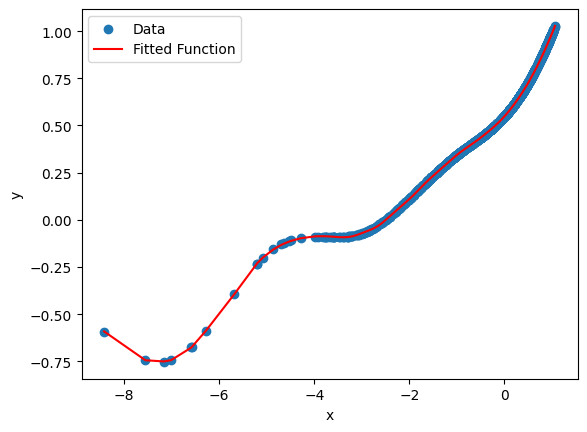

In [24]:
test_res = model(dataset['test_input'])

plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, test_res.detach().numpy().astype(np.float64), label='Fitted Function', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [25]:
lib = ['x','x^2','x^3','x^4','x^5','x^6','x^7','x^8','x^9','x^10','x^11','1/x','1/x^2','1/x^3','1/x^4','sqrt','1/sqrt(x)','exp','log','abs','sin','tan','tanh','sigmoid','relu','sgn','arcsin','arctan','arctanh','0','gaussian','cosh']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with x^2, r2=0.9924361455832319
fixing (0,0,1) with arctan, r2=0.9954286223835683
fixing (1,0,0) with abs, r2=0.9359770572036641
fixing (1,0,1) with tanh, r2=0.917436135219327
fixing (1,1,0) with tan, r2=0.978151529180573
fixing (1,1,1) with tan, r2=0.9693820541382095
fixing (2,0,0) with relu, r2=0.6983438995253194
fixing (2,0,1) with arctan, r2=0.954379418918758
fixing (2,1,0) with arctan, r2=0.975621523726956
fixing (2,1,1) with tan, r2=0.9943048667057864
fixing (3,0,0) with gaussian, r2=0.9963894727716124
fixing (3,1,0) with sin, r2=0.9915734868625624


In [26]:
loss_ = model.train(dataset, opt="LBFGS", steps=20, lr=0.00001)

train loss: 3.35e-02 | test loss: 3.35e-02 | reg: 1.51e+01 : 100%|██| 20/20 [00:05<00:00,  3.88it/s]


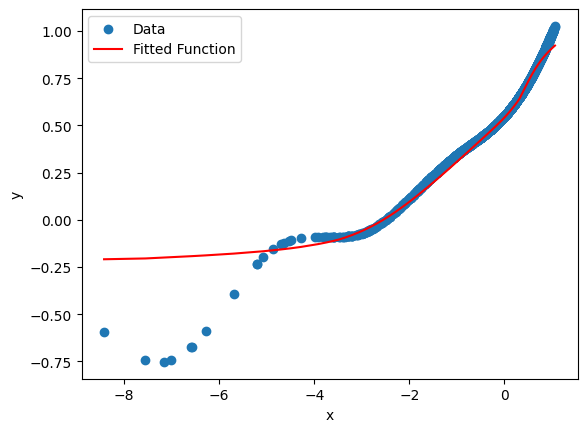

In [27]:
test_res = model(dataset['test_input'])

plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, test_res.detach().numpy().astype(np.float64), label='Fitted Function', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [28]:
formula, variables = model.symbolic_formula()
formula[0]

0.76*sin(0.97*tan(0.23*tan(0.7*atan(0.79*x_1 + 1.87) + 9.61) + 0.06*tanh(6.97*(-0.18*x_1 - 1)**2 - 8.21) + 3.09) + 1.19*atan(0.21*tan(0.64*atan(0.79*x_1 + 1.87) + 9.64) + 0.01*Abs(7.18*(0.18*x_1 + 1)**2 - 1.08) + 0.57) - 1.32) + 0.03 + 0.95*exp(-0.36*(-0.29*atan(1.8*tan(0.7*atan(0.79*x_1 + 1.87) + 9.61) + 0.44*tanh(6.97*(-0.18*x_1 - 1)**2 - 8.21) - 1.93) - 0.3*Max(0, 2.4*tan(0.64*atan(0.79*x_1 + 1.87) + 9.64) + 0.17*Abs(7.18*(0.18*x_1 + 1)**2 - 1.08) - 4.53) + 1)**2)